# Imports

In [3]:
import pandas as pd
from scipy.interpolate import interp1d
from scipy .integrate import cumulative_trapezoid
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras import Loss
import seaborn as sns

2025-04-05 17:41:59.344742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743871319.538074    1032 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743871319.592770    1032 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-05 17:42:00.055995: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Train on single vehicle dynamics

## Constant coefficient car

In [ ]:
class SecondOrderCar:
    def __init__(self, x0: tuple, m: float, Af: float, to_estimate: tuple):
        #vehicle params:
        # known
        self.m = m
        self.Af = Af
        #unkowns
        self.road_grade, self.c0, self.c1, self.p, self.Cd = to_estimate
        self.x0 = x0
        self.X = np.array(self.x0, dtype=np.float32) #[position, velocity]

        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }

        self.dX_hist = [(0.0, 0.0)]

    def update(self, u, dt):
        """Update state for one time step using fixed-step integration"""

        # Store history
        self.history['x'].append(self.X[0])
        self.history['v'].append(self.X[1])
        self.history['u'].append(u)


        # runge-kutta
        # k1 = self._dynamics(self.X, u)
        # a = k1[1] #gets v_dot = actual acceleration
        # self.history["a"].append(a)

        # k2 = self._dynamics(self.X + 0.5*dt*k1, u)
        # k3 = self._dynamics(self.X + 0.5*dt*k2, u)
        # k4 = self._dynamics(self.X + dt*k3, u)

        # self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        # self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        # self.X += (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
        
        dX_prev = self.dX_hist[-1]
        dX = self._dynamics(self.X, u)
        self.dX_hist.append(dX)
        
        self.history["a"].append(dX[1])
        #trapezoid integral step:
        self.X[0] += (dX[0]+dX_prev[0])*dt/2
        self.X[1] += (dX[1]+dX_prev[1])*dt/2

    def _dynamics(self, X, u):
        '''Vehicle Dynamics in State-Space form'''
        g = 9.81
        x, v = X
        Fr = (self.c0 + self.c1 * v)*(self.m*g*np.cos(self.road_grade))
        Fa = (self.p*self.Cd*self.Af*v**2)/2
        Fg = self.m*g*np.sin(self.road_grade)

        a = (u - Fr - Fa - Fg)/self.m #Assumes instant actuation u (traction force)
        #return np.array([v,a])
        return (v, a)
    
    def reset(self, x0):
        del self.history
        self.history = {
            "x": [], "v": [], "u": [], "a": []
        }
        self.X = np.array(x0, dtype=np.float32) #[position, velocity]
        self.dX_hist = [(0.0, 0.0)]
        

## Generate synthetic data

   traj_id    t      u    a_meas    a_true   v_true_m  v_true_km    x_true
0      0.0  0.0  510.0 -0.003047 -0.000861  13.888889  50.000000  0.000000
1      0.0  0.1  510.0 -0.008493 -0.000861  13.888846  49.999847  0.694444
2      0.0  0.2  510.0 -0.008632 -0.000860  13.888761  49.999538  2.083331
3      0.0  0.3  510.0  0.017634 -0.000860  13.888675  49.999229  3.472212
4      0.0  0.4  510.0 -0.007915 -0.000859  13.888589  49.998920  4.861084


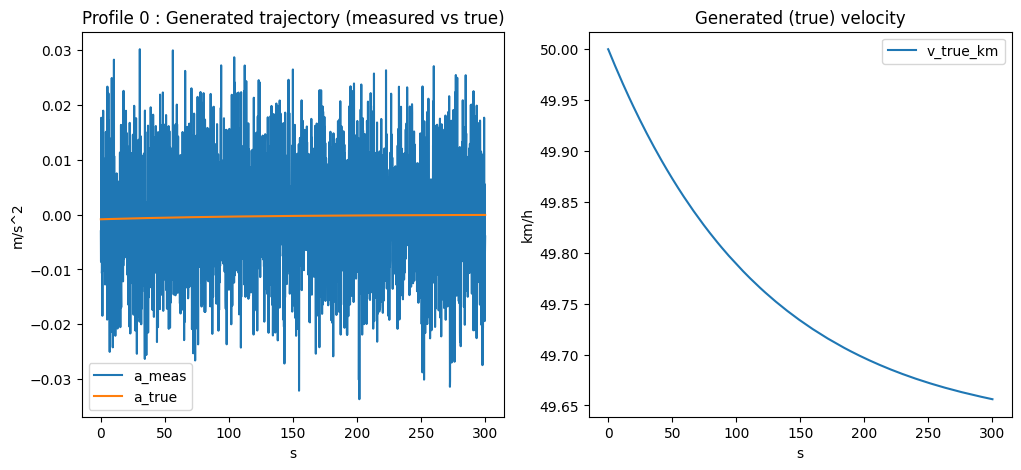

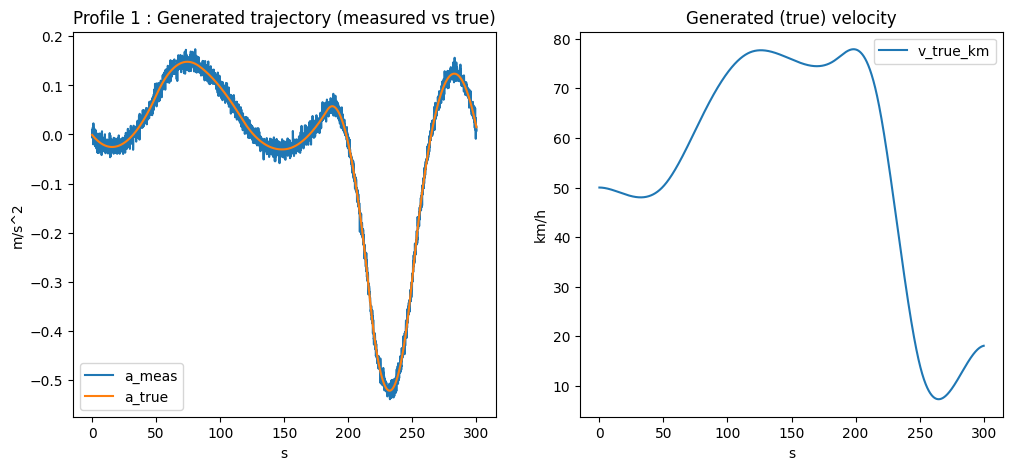

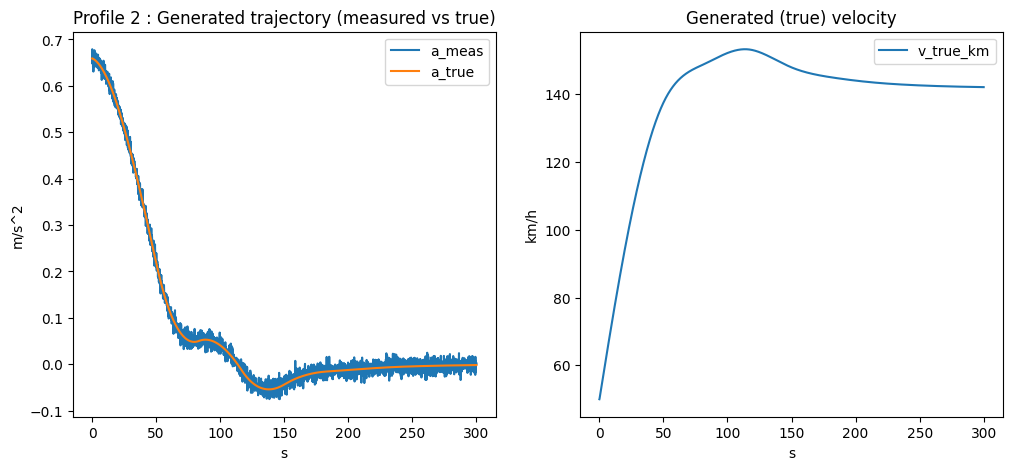

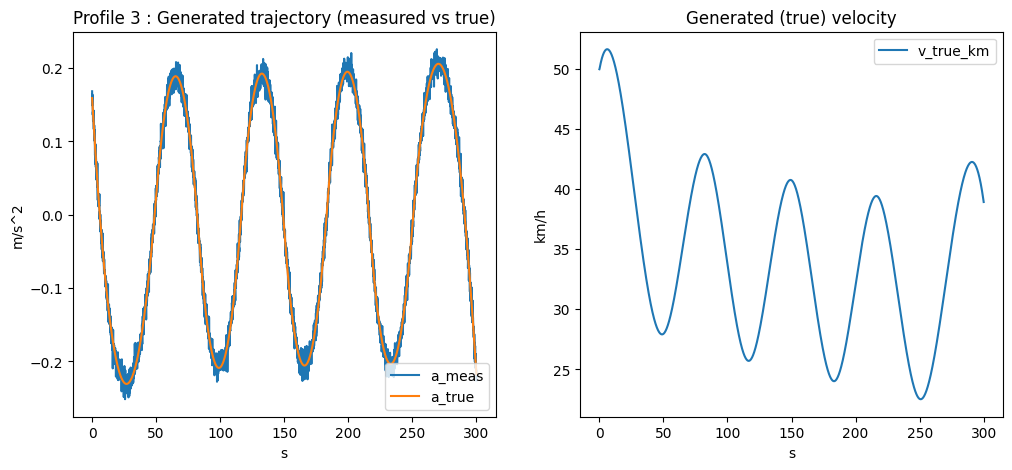

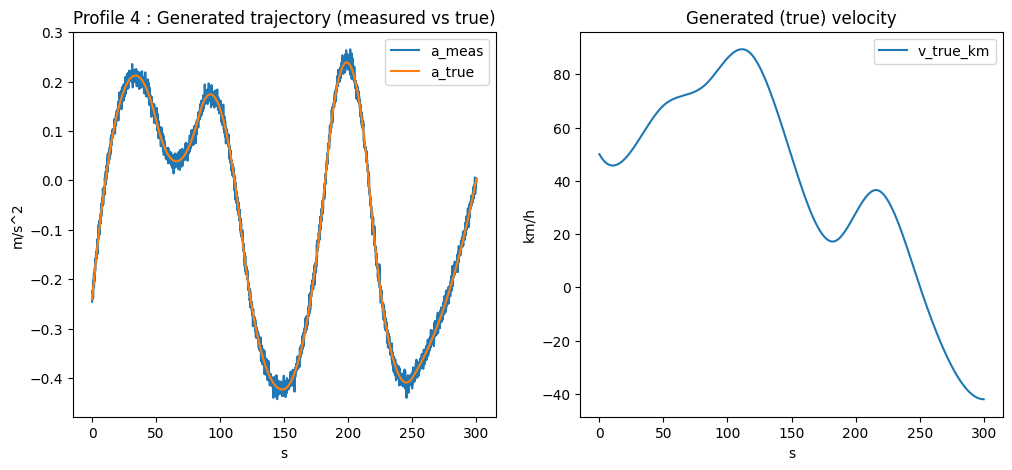

In [45]:
# random value from https://www.chegg.com/homework-help/questions-and-answers/top-speed-vehicle-analytical-toolbox-consider-typical-sedan-car-following-parameters-mass--q109159050
v0 = 50/3.6
x0 = (0, v0) #at origin and 20km/h
m = 1500 #kg toyota prius 2001 curb weight
# https://en.wikipedia.org/wiki/Automobile_drag_coefficient
Af = 2.1 # average drag (cross sectional) area
Cd = 0.27 #toyota prius 2001
p = 1.204 #average air density
#rolling resistance:
c0 = 0.0075
c1 = 2*10**-4
road_grade = np.atan(2/100) #in radians, 2% slope
to_estimate = (road_grade, c0, c1, p, Cd)

car = SecondOrderCar(x0, m, Af, to_estimate)
t_end = 300
dt = 0.1
t = np.arange(0, t_end+dt, dt)
t_samp = np.linspace(0, t_end, 10, dtype=np.float32)
std = 1e-2

#DEFINE U PROFILES
input_profiles = []
input_profiles.append(np.full_like(t_samp, 0.34, dtype=np.float32) * m) #crusing
input_profiles.append(np.array([0.34, 0.34, 0.5, 0.5, 0.4, 0.4, 0.4, -0.2, 0.3, 0.3], dtype=np.float32) * m) #emerg braking
input_profiles.append(np.array([1.0, 1.0, 0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7], dtype=np.float32) * m) #accelerating
input_profiles.append(np.array([0.5, 0.1]*5, dtype=np.float32) * m) #stop&go/oscillating
np.random.seed(31)
input_profiles.append(np.random.uniform(low=-0.1, high=0.6, size=t_samp.shape).astype(np.float32) * m) #random

input_interp = []
for profile in input_profiles:
    input_interp.append(interp1d(t_samp, profile, kind='quadratic'))

#simulate and build dataframes
def simulate_traj(car, u_func, traj_id, t):
    for t_curr in t:
        car.update(u_func(t_curr), dt)
    data = {
        'traj_id': traj_id,
        't': t,
        'u': car.history["u"],
        'a_meas': np.array(car.history["a"]) + np.random.normal(loc=0, scale=std, size=len(t)),
        'a_true': car.history["a"],
        'v_true_m': car.history["v"],
        'v_true_km': np.array(car.history["v"])*3.6,
        'x_true': car.history["x"],
    }

    return pd.DataFrame(data, dtype=np.float32)

dataframes = []
for id, func in enumerate(input_interp):
    dataframe = simulate_traj(car, func, id, t)

    #plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    dataframe.plot(x='t', y=["a_meas", "a_true"], ax=axs[0],
               title="Profile " + str(id) + " : Generated trajectory (measured vs true)",
               legend=True, ylabel="m/s^2", xlabel="s")
    dataframe.plot(x='t', y="v_true_km", ax=axs[1],
               title="Generated (true) velocity",
               legend=True, ylabel="km/h", xlabel="s")

    dataframes.append(dataframe)
    car.reset(x0) #x0 common for all trajectories

dataset = pd.concat(dataframes, axis=0, ignore_index=True)
dataset.to_csv("data/synthetic_5_trajectories.csv", index=False)
print(dataset.head())

## Helper funcs

In [46]:
def comparison_plot(t: np.ndarray, true_data: np.ndarray,
                     pred_data: list[tuple[np.ndarray, str]], suptitle: str, meas_data: np.ndarray = None):
    '''
    true_data: contains acc, vel (in m/s), and pos in (t, 3) shape
    '''

    # Plot the true vs predicted values for position and velocity:
    plt.figure(figsize=(12, 8))
    plt.suptitle(suptitle)

    # Plot for acceleration:
    plt.subplot(1, 3, 1)
    plt.plot(t, true_data[:, 0], label="True Acceleration", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 0], '--', label=label, linewidth=2)
    if meas_data is not None:
        plt.scatter(t, meas_data, label="Measured acceleration points", s=7)
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s^2)")
    plt.title("Acceleration")
    plt.legend()
    plt.grid()

    # Plot for velocity:
    plt.subplot(1, 3, 2)
    plt.plot(t, true_data[:, 1]*3.6, label="True Velocity", linewidth=2) #conversion from m/s to km/h
    for data, label in pred_data:
        plt.plot(t, data[:, 1]*3.6, '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (km/h)")
    plt.title("Velocity")
    plt.legend()
    plt.grid()


    plt.subplot(1, 3, 3)
    plt.plot(t, true_data[:, 2], label="True Position", linewidth=2)
    for data, label in pred_data:
        plt.plot(t, data[:, 2], '--', label=label, linewidth=2)
    plt.xlabel("Time (s)")
    plt.ylabel("Displacement (m)")
    plt.title("Position")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def loss_plot(history):
    loss = history["loss"]
    val_loss = history["val_loss"]
    stopped_epoch = np.argmin(val_loss) + 1  # Get the epoch with the minimum validation loss

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(loss) + 1), loss, label="Training Loss")
    plt.plot(range(1, len(loss) + 1), val_loss, label="Validation Loss (against ground truth)")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid()
    plt.title("Evolution of training and validation losses")

    # Add a marker for the early stopping epoch
    plt.axvline(x=stopped_epoch, color='r', linestyle='--', label='Early Stopping')
    plt.text(stopped_epoch, val_loss[stopped_epoch - 1], f'({stopped_epoch}, {val_loss[stopped_epoch - 1]:.5e})',
             color='b', fontsize=12)

    plt.legend()
    plt.show()

def evaluate_results(model, X_norm, true_data):
    v = np.zeros_like(t)
    x = np.zeros_like(t)

    pred_a = model.predict(X_norm)
    v = cumulative_trapezoid(y=pred_a.flatten(), dx=dt, initial=0)  # Velocity (m/s)
    v += x0[1]
    x = cumulative_trapezoid(y=v, dx=dt, initial=0)
    x += x0[0]  

    mse_a = mean_squared_error(true_data[:, 0], pred_a)
    mse_v = mean_squared_error(true_data[:, 1], v)
    mse_x = mean_squared_error(true_data[:, 2], x)

    v = v.reshape(-1, 1)
    x = x.reshape(-1, 1)

    pred_data = np.hstack((pred_a, v, x))

    print(f"MSE/RMSE for acceleration: {mse_a:.5e}, {np.sqrt(mse_a):.5e}")
    print(f"MSE/RMSE for velocity: {mse_v:.5e}, {np.sqrt(mse_v):.5e}")
    print(f"MSE/RMSE for position: {mse_x:.5e}, {np.sqrt(mse_x):.5e}")

    return pred_data

# Prepping data

**for now only using one of the trajectories for training although I had made a tf.dataset that would have shape (traj, N, features) for parallel training. But that would require changing the models architecture as far as I know for now. Stash that**

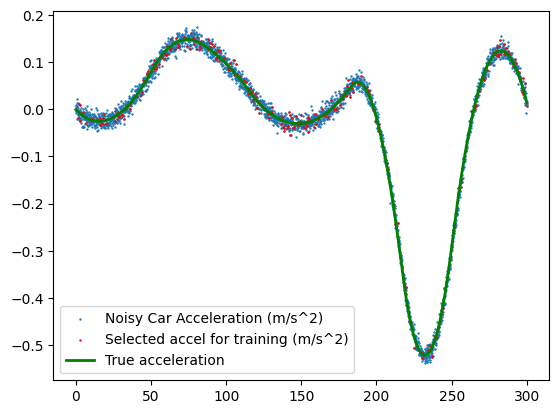

' # Plot histograms for features and outputs using seaborn\nfig, ax = plt.subplots(1, 2, figsize=(12, 5))\nfig.suptitle("After normalization")\n\n# Plot histograms for features\nsns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=ax[0], color=\'blue\')\nax[0].set_title(\'Histogram of Feature t (training)\')\nax[0].set_xlabel(\'t\')\nax[0].set_ylabel(\'Frequency\')\n\nsns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=ax[1], color=\'green\')\nax[1].set_title(\'Histogram of Feature u (training)\')\nax[1].set_xlabel(\'u\')\nax[1].set_ylabel(\'Frequency\')\n\n# Plot histogram for output\nplt.figure(figsize=(6, 5))\nsns.histplot(Y_train, bins=100, kde=True, color=\'orange\')\nplt.title(\'Histogram of Acceleration (training)\')\nplt.xlabel(\'Acceleration\')\nplt.ylabel(\'Frequency\')\n\nplt.tight_layout()\nplt.show() '

In [47]:
train_ratio = .1 #data sparsity
train_id = 1 #traj id 
test_id = 3 

df_train_traj = dataset[dataset['traj_id'] == train_id]
df_test_traj = dataset[dataset['traj_id'] == test_id]
X = df_train_traj[["t", "u", "v_true_m", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N
X_test = df_test_traj[["t", "u", "v_true_m", "x_true"]].to_numpy() #control input + states + time dependency -> shape 4, N

Y_noise = df_train_traj[["a_meas"]].to_numpy() #shape N, 1
Y_true = df_train_traj[["a_true"]].to_numpy() #shape N, 1
Y_test = df_test_traj[["a_true"]].to_numpy()

Y_train, Y_val, X_train, X_val = train_test_split(Y_noise, X, train_size=train_ratio, random_state=31)
#print(Y_train.shape) #only 10% of measurements (sparse dataset)

#Visualize training data provided to model:
mask = np.isin(Y_noise, Y_train)
Y_mask = Y_noise.copy()
Y_mask[~mask] = np.nan
plt.scatter(t, Y_noise, label="Noisy Car Acceleration (m/s^2)", s=.5)
plt.scatter(t, Y_mask, label="Selected accel for training (m/s^2)", s=.5, color="red")
plt.plot(t, Y_true, label="True acceleration", linewidth=2, color="green")
plt.legend()
plt.show()

""" #Prediction Normalization
# not doing this now
scaler_Y = StandardScaler().fit(Y_train)
Y_train_norm = scaler_Y.transform(Y_train)
Y_val_norm = scaler_Y.transform(Y_val)
Y_true_norm = scaler_Y.transform(Y_true)
y_0_norm = Y_true_norm[0, :] """

# feature normalization all based on the training distribution
scaler_X = MinMaxScaler().fit(X_train)
X_train_norm = scaler_X.transform(X_train)
X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)
X_norm = scaler_X.transform(X)
x0_norm = X_norm[0, :]
y0_true = Y_true[0, :]

""" # Plot histograms for features and outputs using seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("After normalization")

# Plot histograms for features
sns.histplot(X_train_norm[:, 0], bins=100, kde=True, ax=ax[0], color='blue')
ax[0].set_title('Histogram of Feature t (training)')
ax[0].set_xlabel('t')
ax[0].set_ylabel('Frequency')

sns.histplot(X_train_norm[:, 1], bins=100, kde=True, ax=ax[1], color='green')
ax[1].set_title('Histogram of Feature u (training)')
ax[1].set_xlabel('u')
ax[1].set_ylabel('Frequency')

# Plot histogram for output
plt.figure(figsize=(6, 5))
sns.histplot(Y_train, bins=100, kde=True, color='orange')
plt.title('Histogram of Acceleration (training)')
plt.xlabel('Acceleration')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show() """

# PUNN-only

I0000 00:00:1743873262.893416    1032 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1989 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/2000


I0000 00:00:1743873265.265992   15421 service.cc:148] XLA service 0x7f6224004680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743873265.266418   15421 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-04-05 18:14:25.316220: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743873265.477427   15421 cuda_dnn.cc:529] Loaded cuDNN version 90300


11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0315

I0000 00:00:1743873266.395658   15421 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0298

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - loss: 0.0296 - val_loss: 0.0457 - learning_rate: 1.0000e-04
Epoch 2/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0205 - val_loss: 0.0613 - learning_rate: 1.0000e-04
Epoch 3/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0126 - val_loss: 0.0754 - learning_rate: 1.0000e-04
Epoch 4/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0106 - val_loss: 0.1096 - learning_rate: 1.0000e-04
Epoch 5/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0069 - val_loss: 0.1443 - learning_rate: 1.0000e-04
Epoch 6/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0057 - val_loss: 0.1763 - learning_rate: 1.0000e-04
Epoch 7/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0054 - val_loss: 0.2145 - learning_rate: 1.0000e-04
Epoch 8/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0046 - val_loss: 0.2376 - learning_rate: 1.0000e-04
Epoch 9/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0033 - val_loss: 0.2529 - lea

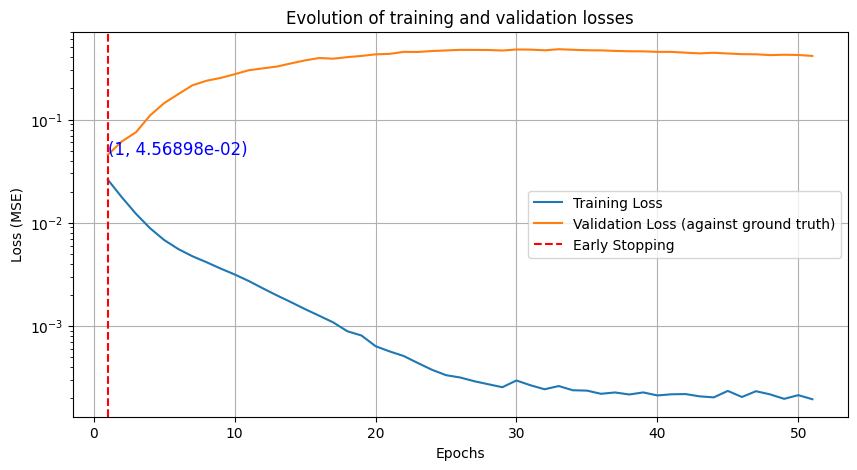

In [ ]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 150
start_from_epoch = 200
loss = "mse"
metrics = []
schedule_tg = 100
opt = Adam(learning_rate=1e-4, weight_decay=1e-3)
batch = 16
#------

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)
def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/punn_model_forward.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#PUNN
punn_model = Sequential()
punn_model.add(Input(shape=(n_features, ))) #_ for batch dim
for _ in range(0,n_hid_layers):
    punn_model.add(Dense(n_neurons, activation=act))
punn_model.add(Dense(1, activation="linear")) #output layer -> a^
punn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#punn_model.summary()
#with output scaling:
history_punn_fwd = punn_model.fit(x=X_train_norm, y=Y_train, validation_data=(X_val, Y_val),
                                  batch_size=batch, epochs=epochs, callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_punn_fwd.history)

In [32]:
punn_model.save("models/punn_model_forward.h5")

## PUNN predictions
offline integration for testing, in reality it would be real-time

## Training trajectory

Training trajectory (1) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE/RMSE for acceleration: 3.66711e-04, 1.91497e-02
MSE/RMSE for velocity: 9.43707e-01, 9.71446e-01
MSE/RMSE for position: 2.55391e+04, 1.59810e+02
----


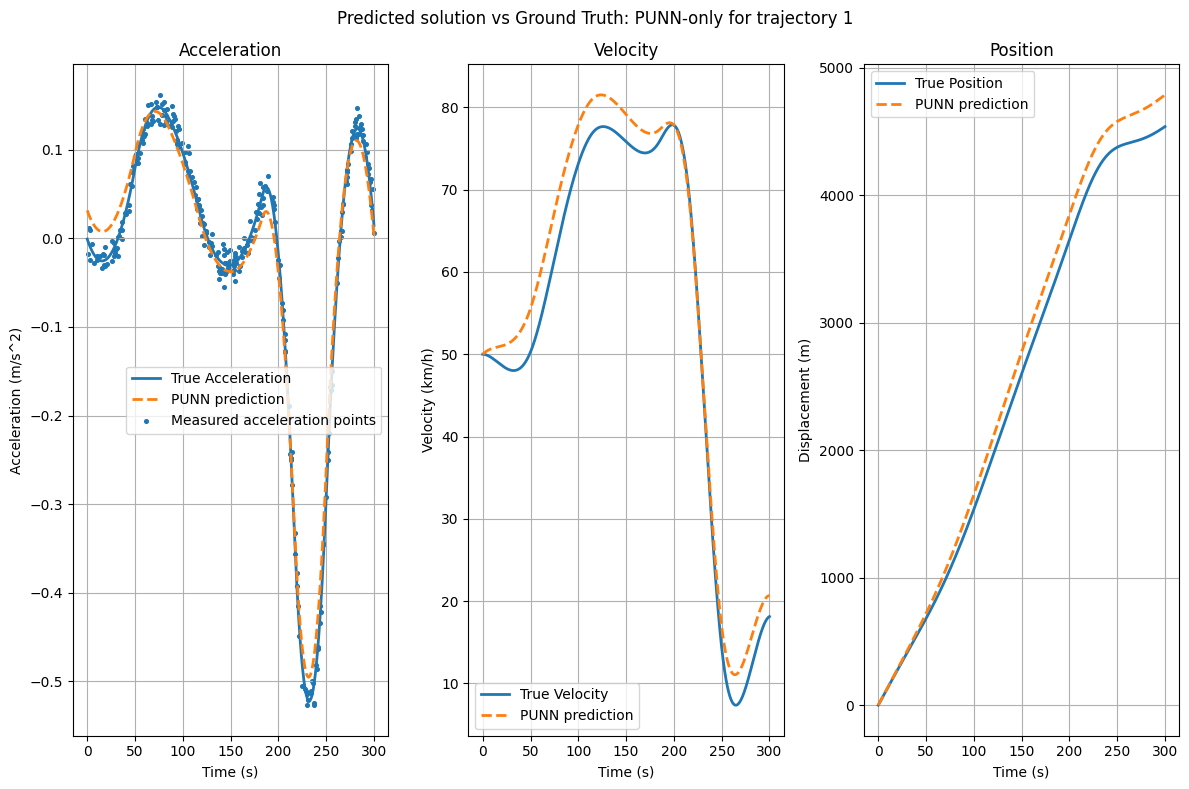

In [64]:
true_data = df_train_traj[["a_true", "v_true_m", "x_true"]].to_numpy()
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
print("Training trajectory (" + str(train_id) + ") statistics: ")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=X_norm, true_data=true_data)
print("----")
comparison_plot(t=t, true_data=true_data, meas_data=Y_mask,
    pred_data=[(punn_train_traj_eval, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory " + str(train_id)
)


## Testing trajectory (generalization ability)

Testing trajectory (3) statistics: 
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE/RMSE for acceleration: 1.30506e-03, 3.61257e-02
MSE/RMSE for velocity: 4.08012e+01, 6.38758e+00
MSE/RMSE for position: 6.34534e+05, 7.96576e+02
----


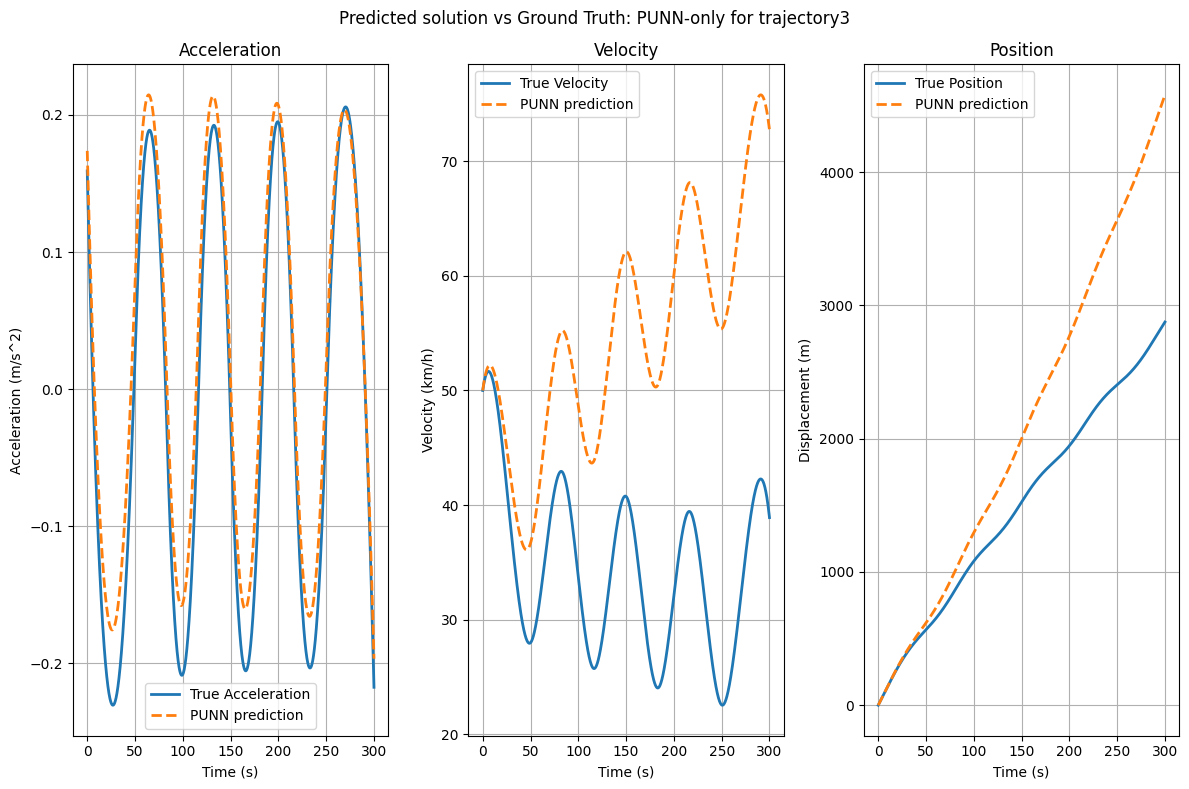

In [65]:
true_data_test = df_test_traj[["a_true", "v_true_m", "x_true"]].to_numpy()
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
print("Testing trajectory (" + str(test_id) + ") statistics: ")
punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=true_data_test)
print("----")
comparison_plot(t=t, true_data=true_data_test, meas_data=None,
    pred_data=[(punn_test_traj_eval, "PUNN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory" + str(test_id)
)

# PINN

## Combined Loss

In [29]:
#not using this now
# def tf_cumulative_trapezoid(y, x):
#     """
#     Computes cumulative integral using the trapezoidal rule without breaking tensor computational graph
#     Both y and x must be 1D tensors of the same length.
#     """
#     dx = x[1:] - x[:-1]
#     areas = 0.5 * (y[1:] + y[:-1]) * dx
#     return tf.concat([[0.0], tf.math.cumsum(areas)], axis=0)


In [9]:
collocation_size = int(len(t)/4)
print("Number of collocation points: " + str(collocation_size))
t_c = np.linspace(start=0, stop=t_end, num=collocation_size) #collocation points -> uniform sampling for now
u_c = input_interp[train_id] #get u from correct trajectory function
car.reset(x0)
df_c = simulate_traj(car=car, u_func=u_c, traj_id=train_id, t=t_c) 
df_c.to_csv("data/train_traj_collocation.csv")
X_c = df_c[["t", "u", "v_true_m", "x_true"]].to_numpy()
X_c_norm = scaler_X.transform(X_c)

class CombinedLoss(Loss):
    def __init__(self, car, model: keras.Model, X_c_norm: np.ndarray, y0: np.ndarray, x0_norm: np.ndarray,
                 scaler_X: MinMaxScaler, loss_weights: tuple[float, float, float], scaler_Y=None):
        super().__init__()
        
        self.car = car
        self.model = model
        self.alpha_d, self.alpha_p, self.alpha_b = loss_weights

        #IC
        self.y0 = y0 #acc
        #self.v0 = v0 
        self.x0_norm = x0_norm
        #self.scaler_Y = scaler_Y
        self.scaler_X = scaler_X

        self.X_c_norm = tf.convert_to_tensor(X_c_norm, dtype=tf.float32)

        X_c_denorm = scaler_X.inverse_transform(X_c_norm)
        self.t_c, self.u, self.v, self.x = (tf.constant(X_c_denorm[:, i]) for i in range(X_c_denorm.shape[1]))

    def data_loss(self, y_true, y_pred):
        sqr_diff = tf.square(y_true - y_pred)
        return tf.reduce_mean(sqr_diff)

    def physics_loss(self):
        g = 9.81
        car = self.car

        a = self.model(self.X_c_norm) #use PUNN to predict on collocation points
        a = tf.reshape(a, shape=([-1])) #flatten for shape matching
        #denormalize
        #a_phy = a_norm * self.scaler_Y.scale_ + self.scaler_Y.mean_ #denorm
        #a_phy = keras.ops.ravel(a_phy) #-> 1D
        #v_phy = self.v0 + tf_cumulative_trapezoid(a_phy, self.t_c) -> wrong, should use state
        
        #print(a.shape, self.v.shape, self.u.shape, (self.v**2).shape)
        #resistive forces
        Fr = (car.c0 + car.c1 * self.v) * (car.m * g * np.cos(car.road_grade))
        Fa = (car.p * car.Cd * car.Af * self.v**2) / 2
        Fg = car.m * g * np.sin(car.road_grade)
    
        
        #physics residuals
        res = car.m * a - (self.u - Fr - Fa - Fg)  # Newton's law

        return tf.reduce_mean(tf.square(res))

    def boundary_loss(self):
        y0_pred = self.model(self.x0_norm[tf.newaxis, :]) #add batch shape 
        sqr_diff = tf.square(y0_pred - self.y0)
        return tf.reduce_mean(sqr_diff)

    def call(self, y_true, y_pred):
        data_loss = self.data_loss(y_true, y_pred)
        pde_loss = self.physics_loss()
        bound_loss = self.boundary_loss()

        return (
            self.alpha_d * data_loss +
            self.alpha_p * pde_loss +
            self.alpha_b * bound_loss
        )

Number of collocation points: 750


## Training

Epoch 1/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 953279.0000 - mse: 0.4067

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - loss: 930359.2500 - mse: 0.3981 - val_loss: 66383.9766 - val_mse: 0.0262 - learning_rate: 0.0100
Epoch 2/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32810.4648 - mse: 0.0180

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - loss: 32286.7129 - mse: 0.0178 - val_loss: 7837.4526 - val_mse: 0.0113 - learning_rate: 0.0100
Epoch 3/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6073.0356 - mse: 0.0107

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 5981.6187 - mse: 0.0106 - val_loss: 2716.7815 - val_mse: 0.0099 - learning_rate: 0.0100
Epoch 4/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1715.7550 - mse: 0.0076

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 1698.8368 - mse: 0.0075 - val_loss: 855.0712 - val_mse: 0.0046 - learning_rate: 0.0100
Epoch 5/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 793.2972 - mse: 0.0045

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 779.3546 - mse: 0.0044 - val_loss: 511.1863 - val_mse: 0.0032 - learning_rate: 0.0100
Epoch 6/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 455.5770 - mse: 0.0034

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 443.5440 - mse: 0.0033 - val_loss: 281.4836 - val_mse: 0.0026 - learning_rate: 0.0100
Epoch 7/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 246.2428 - mse: 0.0024

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 240.7772 - mse: 0.0024 - val_loss: 141.8380 - val_mse: 0.0021 - learning_rate: 0.0100
Epoch 8/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 119.4717 - mse: 0.0023 - val_loss: 65.6035 - val_mse: 0.0021 - learning_rate: 0.0100
Epoch 9/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 54.3761 - mse: 0.0024 - val_loss: 28.3647 - val_mse: 0.0022 - learning_rate: 0.0100
Epoch 10/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - loss: 23.4386 - mse: 0.0024 - val_loss: 12.4929 - val_mse: 0.0024 - learning_rate: 0.0100
Epoch 11/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 10.6047 - mse: 0.0025 - val_loss: 6.5935 - val_mse: 0.0025 - learning_rate: 0.0100
Epoch 12/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 5.9623 - mse: 0.0026 - val_loss: 4.6719 - val_mse: 0.0026 - learning_rate: 0.0100
Epoch 13/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.4837 - mse: 0.0027 - val_loss: 4.1074 - val_mse: 0.0026 - learning_rate: 0.

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 2.7526 - mse: 0.0022 - val_loss: 2.7320 - val_mse: 0.0021 - learning_rate: 0.0100
Epoch 54/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7271 - mse: 0.0022

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 2.7253 - mse: 0.0022 - val_loss: 2.7048 - val_mse: 0.0021 - learning_rate: 0.0100
Epoch 55/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6985 - mse: 0.0022 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.6982 - mse: 0.0022 - val_loss: 2.6778 - val_mse: 0.0021 - learning_rate: 0.0100
Epoch 56/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6716 - mse: 0.0022 

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 2.6713 - mse: 0.0022 - val_loss: 2.6511 - val_mse: 0.0021 - learning_rate: 0.0100
Epoch 57/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6466 - mse: 0.0022

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.6446 - mse: 0.0022 - val_loss: 2.6245 - val_mse: 0.0021 - learning_rate: 0.0100
Epoch 58/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6196 - mse: 0.0023

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 2.6183 - mse: 0.0023 - val_loss: 2.5982 - val_mse: 0.0021 - learning_rate: 0.0100
Epoch 59/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5929 - mse: 0.0022

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 2.5919 - mse: 0.0022 - val_loss: 2.5722 - val_mse: 0.0020 - learning_rate: 0.0100
Epoch 60/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5678 - mse: 0.0024

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.5661 - mse: 0.0023 - val_loss: 2.5464 - val_mse: 0.0020 - learning_rate: 0.0100
Epoch 61/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5404 - mse: 0.0021

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 2.5401 - mse: 0.0021 - val_loss: 2.5207 - val_mse: 0.0020 - learning_rate: 0.0100
Epoch 62/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5153 - mse: 0.0022

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 2.5146 - mse: 0.0022 - val_loss: 2.4954 - val_mse: 0.0020 - learning_rate: 0.0100
Epoch 63/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4915 - mse: 0.0024 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.4895 - mse: 0.0023 - val_loss: 2.4702 - val_mse: 0.0020 - learning_rate: 0.0100
Epoch 64/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4660 - mse: 0.0020

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.4641 - mse: 0.0021 - val_loss: 2.4453 - val_mse: 0.0020 - learning_rate: 0.0100
Epoch 65/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4415 - mse: 0.0022 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 2.4393 - mse: 0.0022 - val_loss: 2.4205 - val_mse: 0.0020 - learning_rate: 0.0100
Epoch 66/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4152 - mse: 0.0021

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 2.4146 - mse: 0.0021 - val_loss: 2.3960 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 67/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3923 - mse: 0.0021 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.3901 - mse: 0.0021 - val_loss: 2.3718 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 68/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3674 - mse: 0.0020

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.3659 - mse: 0.0020 - val_loss: 2.3477 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 69/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3441 - mse: 0.0021 

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 2.3420 - mse: 0.0021 - val_loss: 2.3239 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 70/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.3194 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 2.3180 - mse: 0.0019 - val_loss: 2.3003 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 71/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.2964 - mse: 0.0020

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 2.2946 - mse: 0.0020 - val_loss: 2.2769 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 72/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.2720 - mse: 0.0022

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 2.2715 - mse: 0.0022 - val_loss: 2.2537 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 73/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2484 - mse: 0.0020

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.2482 - mse: 0.0020 - val_loss: 2.2307 - val_mse: 0.0019 - learning_rate: 0.0100
Epoch 74/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2256 - mse: 0.0021 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.2253 - mse: 0.0021 - val_loss: 2.2080 - val_mse: 0.0018 - learning_rate: 0.0100
Epoch 75/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2039 - mse: 0.0022

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 2.2027 - mse: 0.0022 - val_loss: 2.1854 - val_mse: 0.0018 - learning_rate: 0.0100
Epoch 76/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.1802 - mse: 0.0019

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 2.1800 - mse: 0.0019 - val_loss: 2.1631 - val_mse: 0.0018 - learning_rate: 0.0100
Epoch 77/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1587 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 2.1576 - mse: 0.0019 - val_loss: 2.1409 - val_mse: 0.0018 - learning_rate: 0.0100
Epoch 78/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1367 - mse: 0.0019

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 2.1356 - mse: 0.0019 - val_loss: 2.1190 - val_mse: 0.0018 - learning_rate: 0.0100
Epoch 79/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 2.1149 - mse: 0.0022

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 2.1140 - mse: 0.0022 - val_loss: 2.0973 - val_mse: 0.0018 - learning_rate: 0.0100
Epoch 80/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.0930 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.0920 - mse: 0.0018 - val_loss: 2.0758 - val_mse: 0.0018 - learning_rate: 0.0100
Epoch 81/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0708 - mse: 0.0019

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 2.0706 - mse: 0.0019 - val_loss: 2.0544 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 82/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0496 - mse: 0.0019

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 2.0494 - mse: 0.0019 - val_loss: 2.0333 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 83/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0290 - mse: 0.0019

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 2.0282 - mse: 0.0019 - val_loss: 2.0124 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 84/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0088 - mse: 0.0017

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 2.0073 - mse: 0.0018 - val_loss: 1.9916 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 85/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.9882 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.9866 - mse: 0.0018 - val_loss: 1.9711 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 86/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9664 - mse: 0.0019 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.9662 - mse: 0.0019 - val_loss: 1.9507 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 87/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9465 - mse: 0.0017

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.9458 - mse: 0.0018 - val_loss: 1.9305 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 88/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9267 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.9257 - mse: 0.0018 - val_loss: 1.9105 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 89/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9067 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.9057 - mse: 0.0018 - val_loss: 1.8907 - val_mse: 0.0017 - learning_rate: 0.0100
Epoch 90/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8865 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 1.8858 - mse: 0.0017 - val_loss: 1.8711 - val_mse: 0.0016 - learning_rate: 0.0100
Epoch 91/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.8665 - mse: 0.0017

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 1.8663 - mse: 0.0017 - val_loss: 1.8516 - val_mse: 0.0016 - learning_rate: 0.0100
Epoch 92/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.8495 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.8470 - mse: 0.0018 - val_loss: 1.8323 - val_mse: 0.0016 - learning_rate: 0.0100
Epoch 93/2000
11/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8300 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 1.8278 - mse: 0.0018 - val_loss: 1.8133 - val_mse: 0.0016 - learning_rate: 0.0100
Epoch 94/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8101 - mse: 0.0017

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 1.8087 - mse: 0.0017 - val_loss: 1.7943 - val_mse: 0.0016 - learning_rate: 0.0100
Epoch 95/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7907 - mse: 0.0017

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 1.7898 - mse: 0.0017 - val_loss: 1.7756 - val_mse: 0.0016 - learning_rate: 0.0100
Epoch 96/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7717 - mse: 0.0019 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 1.7712 - mse: 0.0018 - val_loss: 1.7570 - val_mse: 0.0016 - learning_rate: 0.0100
Epoch 97/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7530 - mse: 0.0017 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.7525 - mse: 0.0017 - val_loss: 1.7386 - val_mse: 0.0016 - learning_rate: 0.0100
Epoch 98/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7352 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.7341 - mse: 0.0016 - val_loss: 1.7203 - val_mse: 0.0015 - learning_rate: 0.0100
Epoch 99/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.7179 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.7160 - mse: 0.0017 - val_loss: 1.7022 - val_mse: 0.0015 - learning_rate: 0.0100
Epoch 100/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6989 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 1.6983 - mse: 0.0016 - val_loss: 1.6861 - val_mse: 0.0015 - learning_rate: 0.0090
Epoch 101/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6830 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.6822 - mse: 0.0016 - val_loss: 1.6701 - val_mse: 0.0015 - learning_rate: 0.0090
Epoch 102/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6671 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 1.6663 - mse: 0.0016 - val_loss: 1.6542 - val_mse: 0.0015 - learning_rate: 0.0090
Epoch 103/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6507 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 1.6503 - mse: 0.0016 - val_loss: 1.6384 - val_mse: 0.0015 - learning_rate: 0.0090
Epoch 104/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6358 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 1.6346 - mse: 0.0016 - val_loss: 1.6227 - val_mse: 0.0015 - learning_rate: 0.0090
Epoch 105/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6194 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.6190 - mse: 0.0016 - val_loss: 1.6071 - val_mse: 0.0015 - learning_rate: 0.0090
Epoch 106/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6040 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.6034 - mse: 0.0016 - val_loss: 1.5917 - val_mse: 0.0015 - learning_rate: 0.0090
Epoch 107/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5893 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.5879 - mse: 0.0015 - val_loss: 1.5763 - val_mse: 0.0015 - learning_rate: 0.0090
Epoch 108/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5745 - mse: 0.0018

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.5728 - mse: 0.0017 - val_loss: 1.5611 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 109/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5576 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 1.5574 - mse: 0.0015 - val_loss: 1.5460 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 110/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.5428 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.5423 - mse: 0.0015 - val_loss: 1.5310 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 111/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.5280 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 1.5274 - mse: 0.0016 - val_loss: 1.5160 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 112/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5137 - mse: 0.0014 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.5124 - mse: 0.0015 - val_loss: 1.5012 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 113/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4979 - mse: 0.0015 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.4977 - mse: 0.0015 - val_loss: 1.4865 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 114/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4833 - mse: 0.0015 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 1.4830 - mse: 0.0015 - val_loss: 1.4719 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 115/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4688 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 1.4685 - mse: 0.0015 - val_loss: 1.4575 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 116/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.4549 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.4540 - mse: 0.0015 - val_loss: 1.4431 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 117/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4403 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.4397 - mse: 0.0016 - val_loss: 1.4288 - val_mse: 0.0014 - learning_rate: 0.0090
Epoch 118/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4265 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.4254 - mse: 0.0015 - val_loss: 1.4146 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 119/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4115 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.4113 - mse: 0.0015 - val_loss: 1.4006 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 120/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3984 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.3973 - mse: 0.0015 - val_loss: 1.3866 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 121/2000
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3846 - mse: 0.0016

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.3833 - mse: 0.0015 - val_loss: 1.3727 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 122/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3698 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.3695 - mse: 0.0015 - val_loss: 1.3590 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 123/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3562 - mse: 0.0014

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.3557 - mse: 0.0014 - val_loss: 1.3453 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 124/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3423 - mse: 0.0014

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.3420 - mse: 0.0014 - val_loss: 1.3317 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 125/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3286 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.3284 - mse: 0.0013 - val_loss: 1.3183 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 126/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3154 - mse: 0.0012    

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.3149 - mse: 0.0012 - val_loss: 1.3049 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 127/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3035 - mse: 0.0015 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.3018 - mse: 0.0014 - val_loss: 1.2916 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 128/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2889 - mse: 0.0014

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.2884 - mse: 0.0014 - val_loss: 1.2784 - val_mse: 0.0013 - learning_rate: 0.0090
Epoch 129/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2760 - mse: 0.0013    

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.2752 - mse: 0.0013 - val_loss: 1.2654 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 130/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2626 - mse: 0.0014

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.2622 - mse: 0.0014 - val_loss: 1.2524 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 131/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2498 - mse: 0.0014

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 1.2493 - mse: 0.0014 - val_loss: 1.2395 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 132/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2374 - mse: 0.0014

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.2364 - mse: 0.0014 - val_loss: 1.2267 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 133/2000
12/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2251 - mse: 0.0014

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 1.2237 - mse: 0.0014 - val_loss: 1.2140 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 134/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2115 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.2109 - mse: 0.0012 - val_loss: 1.2014 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 135/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1993 - mse: 0.0015

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 1.1985 - mse: 0.0014 - val_loss: 1.1889 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 136/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1860 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 1.1859 - mse: 0.0013 - val_loss: 1.1764 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 137/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1743 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 1.1735 - mse: 0.0013 - val_loss: 1.1641 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 138/2000
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1628 - mse: 0.0013 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.1612 - mse: 0.0013 - val_loss: 1.1519 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 139/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1496 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.1490 - mse: 0.0013 - val_loss: 1.1397 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 140/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1374 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.1368 - mse: 0.0012 - val_loss: 1.1277 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 141/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1257 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 1.1248 - mse: 0.0013 - val_loss: 1.1157 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 142/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1133 - mse: 0.0012    

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 1.1128 - mse: 0.0012 - val_loss: 1.1038 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 143/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 1.1013 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 1.1010 - mse: 0.0013 - val_loss: 1.0920 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 144/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0897 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 1.0891 - mse: 0.0012 - val_loss: 1.0803 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 145/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0779 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 1.0776 - mse: 0.0013 - val_loss: 1.0687 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 146/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0665 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 1.0660 - mse: 0.0013 - val_loss: 1.0572 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 147/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0548 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 1.0545 - mse: 0.0013 - val_loss: 1.0457 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 148/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0440 - mse: 0.0013

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 1.0431 - mse: 0.0013 - val_loss: 1.0344 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 149/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0321 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - loss: 1.0317 - mse: 0.0012 - val_loss: 1.0231 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 150/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.0205 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 1.0204 - mse: 0.0012 - val_loss: 1.0119 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 151/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0094 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 1.0093 - mse: 0.0012 - val_loss: 1.0008 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 152/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9984 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.9981 - mse: 0.0011 - val_loss: 0.9898 - val_mse: 0.0011 - learning_rate: 0.0090
Epoch 153/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9877 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.9872 - mse: 0.0012 - val_loss: 0.9789 - val_mse: 0.0010 - learning_rate: 0.0090
Epoch 154/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9767 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.9763 - mse: 0.0012 - val_loss: 0.9680 - val_mse: 0.0010 - learning_rate: 0.0090
Epoch 155/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9659 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.9655 - mse: 0.0012 - val_loss: 0.9573 - val_mse: 0.0010 - learning_rate: 0.0090
Epoch 156/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9548 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.9547 - mse: 0.0011 - val_loss: 0.9466 - val_mse: 0.0010 - learning_rate: 0.0090
Epoch 157/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9445 - mse: 9.9690e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.9440 - mse: 0.0010 - val_loss: 0.9360 - val_mse: 0.0010 - learning_rate: 0.0090
Epoch 158/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9338 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.9335 - mse: 0.0012 - val_loss: 0.9255 - val_mse: 0.0010 - learning_rate: 0.0090
Epoch 159/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9231 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - loss: 0.9230 - mse: 0.0011 - val_loss: 0.9150 - val_mse: 0.0010 - learning_rate: 0.0090
Epoch 160/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.9127 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.9125 - mse: 0.0011 - val_loss: 0.9047 - val_mse: 9.9673e-04 - learning_rate: 0.0090
Epoch 161/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9025 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.9022 - mse: 0.0011 - val_loss: 0.8944 - val_mse: 9.8963e-04 - learning_rate: 0.0090
Epoch 162/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8925 - mse: 0.0010    

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.8920 - mse: 0.0011 - val_loss: 0.8842 - val_mse: 9.8258e-04 - learning_rate: 0.0090
Epoch 163/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8824 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.8819 - mse: 0.0011 - val_loss: 0.8741 - val_mse: 9.7560e-04 - learning_rate: 0.0090
Epoch 164/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8723 - mse: 9.7918e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.8717 - mse: 0.0010 - val_loss: 0.8641 - val_mse: 9.6869e-04 - learning_rate: 0.0090
Epoch 165/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 0.8621 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 0.8618 - mse: 0.0011 - val_loss: 0.8542 - val_mse: 9.6185e-04 - learning_rate: 0.0090
Epoch 166/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8524 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.8519 - mse: 0.0011 - val_loss: 0.8443 - val_mse: 9.5506e-04 - learning_rate: 0.0090
Epoch 167/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8427 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.8420 - mse: 0.0011 - val_loss: 0.8345 - val_mse: 9.4834e-04 - learning_rate: 0.0090
Epoch 168/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8325 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.8323 - mse: 0.0011 - val_loss: 0.8248 - val_mse: 9.4170e-04 - learning_rate: 0.0090
Epoch 169/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8231 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.8226 - mse: 0.0011 - val_loss: 0.8152 - val_mse: 9.3511e-04 - learning_rate: 0.0090
Epoch 170/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8137 - mse: 0.0012

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.8131 - mse: 0.0011 - val_loss: 0.8057 - val_mse: 9.2859e-04 - learning_rate: 0.0090
Epoch 171/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8037 - mse: 0.0010

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.8034 - mse: 0.0010 - val_loss: 0.7962 - val_mse: 9.2215e-04 - learning_rate: 0.0090
Epoch 172/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7946 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.7941 - mse: 0.0011 - val_loss: 0.7869 - val_mse: 9.1576e-04 - learning_rate: 0.0090
Epoch 173/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7852 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.7847 - mse: 0.0011 - val_loss: 0.7776 - val_mse: 9.0945e-04 - learning_rate: 0.0090
Epoch 174/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7758 - mse: 0.0010

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.7754 - mse: 0.0010 - val_loss: 0.7684 - val_mse: 9.0322e-04 - learning_rate: 0.0090
Epoch 175/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7665 - mse: 9.8433e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.7662 - mse: 9.9093e-04 - val_loss: 0.7592 - val_mse: 8.9704e-04 - learning_rate: 0.0090
Epoch 176/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7576 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.7571 - mse: 0.0011 - val_loss: 0.7502 - val_mse: 8.9094e-04 - learning_rate: 0.0090
Epoch 177/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7483 - mse: 9.2858e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.7480 - mse: 9.4038e-04 - val_loss: 0.7412 - val_mse: 8.8493e-04 - learning_rate: 0.0090
Epoch 178/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7394 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 0.7391 - mse: 0.0010 - val_loss: 0.7323 - val_mse: 8.7895e-04 - learning_rate: 0.0090
Epoch 179/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7305 - mse: 9.7443e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.7302 - mse: 9.7778e-04 - val_loss: 0.7235 - val_mse: 8.7306e-04 - learning_rate: 0.0090
Epoch 180/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7216 - mse: 0.0011

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.7215 - mse: 0.0011 - val_loss: 0.7148 - val_mse: 8.6726e-04 - learning_rate: 0.0090
Epoch 181/2000
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7132 - mse: 9.2522e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - loss: 0.7127 - mse: 9.3730e-04 - val_loss: 0.7061 - val_mse: 8.6148e-04 - learning_rate: 0.0090
Epoch 182/2000
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7044 - mse: 9.9793e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.7041 - mse: 9.9584e-04 - val_loss: 0.6976 - val_mse: 8.5590e-04 - learning_rate: 0.0090
Epoch 183/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6960 - mse: 9.0778e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 0.6956 - mse: 9.2132e-04 - val_loss: 0.6930 - val_mse: 8.4796e-04 - learning_rate: 0.0090
Epoch 184/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 1.6743 - mse: 9.4664e-04 - val_loss: 87.8765 - val_mse: 0.0012 - learning_rate: 0.0090
Epoch 185/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 608.1769 - mse: 0.0011 - val_loss: 333.0891 - val_mse: 8.8441e-04 - learning_rate: 0.0090
Epoch 186/2000
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 147.5497 - mse: 6.1023e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 141.9043 - mse: 5.9808e-04 - val_loss: 24.5002 - val_mse: 2.2473e-04 - learning_rate: 0.0090
Epoch 187/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 16.7022 - mse: 3.6035e-04 - val_loss: 1.4171 - val_mse: 2.3634e-04 - learning_rate: 0.0090
Epoch 188/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 2.8557 - mse: 3.2633e-04 - val_loss: 1.7173 - val_mse: 2.6470e-04 - learning_rate: 0.0090
Epoch 189/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.3449 - mse: 3.5853e-04 - val_loss: 1.1065 - val_mse: 2.3934e-04 - learning_rate: 0.0090
Epoch 190/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 1.0494 - mse: 3.6600e-04 - val_loss: 1.0060 - val_mse: 2.4763e-04 - learning_rate: 0.0090
Epoch 191/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.9985 - mse: 3.7405e-04 - val_loss: 0.9838 - val_mse: 2.4534e-04 - learning_rate: 0.0090
Epoch 192/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.9798 - mse: 3.8543e-04 - val

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.9840 - mse: 3.8940e-04 - val_loss: 44.5396 - val_mse: 1.4525e-04 - learning_rate: 0.0081
Epoch 231/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 694.3590 - mse: 6.8609e-04 - val_loss: 446.3095 - val_mse: 3.9532e-04 - learning_rate: 0.0081
Epoch 232/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 253.0930 - mse: 5.2632e-04 - val_loss: 11.1569 - val_mse: 2.5760e-04 - learning_rate: 0.0081
Epoch 233/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 29.1478 - mse: 3.3126e-04 - val_loss: 2.4994 - val_mse: 1.5367e-04 - learning_rate: 0.0081
Epoch 234/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 5.0657 - mse: 2.6079e-04 - val_loss: 1.3109 - val_mse: 1.7663e-04 - learning_rate: 0.0081
Epoch 235/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 1.5812 - mse: 2.4612e-04 - val_loss: 1.0322 - val_mse: 1.7148e-04 - learning_rate: 0.0081
Epoch 236/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 1.0830 - mse: 3.0040e-04 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 647.7686 - mse: 7.0809e-04 - val_loss: 19.4951 - val_mse: 1.0955e-04 - learning_rate: 0.0081
Epoch 290/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 49.2536 - mse: 2.3043e-04 - val_loss: 19.4581 - val_mse: 1.3799e-04 - learning_rate: 0.0081
Epoch 291/2000
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.4004 - mse: 1.7764e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 9.6193 - mse: 1.7843e-04 - val_loss: 1.1779 - val_mse: 7.9269e-05 - learning_rate: 0.0081
Epoch 292/2000
14/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.7027 - mse: 1.6910e-04

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.6631 - mse: 1.7184e-04 - val_loss: 1.0318 - val_mse: 7.1765e-05 - learning_rate: 0.0081
Epoch 293/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 1.0478 - mse: 1.8411e-04 - val_loss: 0.9112 - val_mse: 7.3770e-05 - learning_rate: 0.0081
Epoch 294/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.8979 - mse: 1.7400e-04 - val_loss: 0.8603 - val_mse: 7.3870e-05 - learning_rate: 0.0081
Epoch 295/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.8572 - mse: 1.5785e-04 - val_loss: 0.8413 - val_mse: 7.4326e-05 - learning_rate: 0.0081
Epoch 296/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.8368 - mse: 1.6227e-04 - val_loss: 0.8235 - val_mse: 7.4101e-05 - learning_rate: 0.0081
Epoch 297/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.8195 - mse: 1.7955e-04 - val_loss: 0.8070 - val_mse: 7.4103e-05 - learning_rate: 0.0081
Epoch 298/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.8031 - mse: 1.7161e-04 - val_los

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 31.4037 - mse: 1.7938e-04 - val_loss: 10.7707 - val_mse: 3.6496e-05 - learning_rate: 0.0073
Epoch 334/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 5.3276 - mse: 1.5193e-04 - val_loss: 2.0494 - val_mse: 5.6475e-05 - learning_rate: 0.0073
Epoch 335/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 1.5029 - mse: 1.6761e-04 - val_loss: 0.8762 - val_mse: 4.7161e-05 - learning_rate: 0.0073
Epoch 336/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.9142 - mse: 1.6782e-04 - val_loss: 0.8485 - val_mse: 4.6604e-05 - learning_rate: 0.0073
Epoch 337/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.8308 - mse: 1.5053e-04 - val_loss: 0.8036 - val_mse: 4.7528e-05 - learning_rate: 0.0073
Epoch 338/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.7992 - mse: 1.4016e-04 - val_loss: 0.7824 - val_mse: 4.7460e-05 - learning_rate: 0.0073
Epoch 339/2000
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.7776 - mse: 1.3480e-04 - val_l

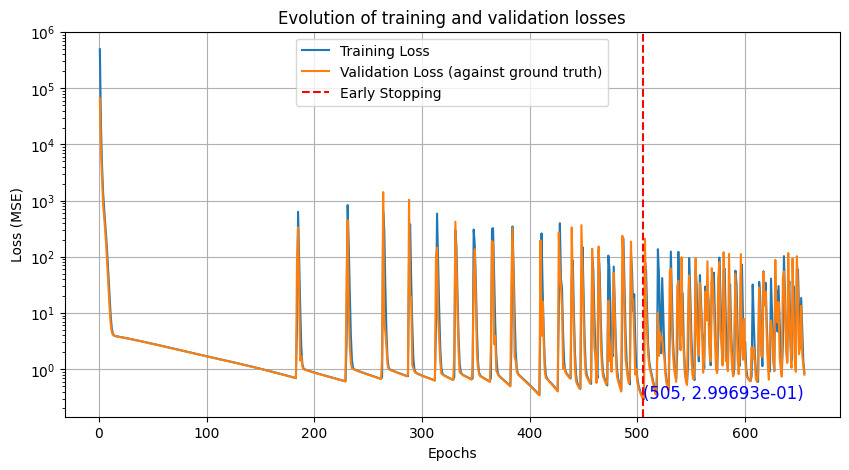

In [ ]:
#globals
#------
n_features = X.shape[1]
n_hid_layers = 3
n_neurons = 64
act = "tanh"
epochs = 2000
patience = 150
start_from_epoch = 200
schedule_tg = 100
metrics = ["mse"]
opt = Adam(learning_rate=1e-2, weight_decay=1e-3)
batch = 16
alpha_d = 1
alpha_p = 1
alpha_b = 1
alpha = alpha_d, alpha_p, alpha_b #weights for different loss components
#------

#PINN
pinn_model = Sequential()
pinn_model.add(Input(shape=(n_features, ))) 
for _ in range(0,n_hid_layers):
    pinn_model.add(Dense(n_neurons, activation=act))
pinn_model.add(Dense(1, activation="linear")) #output layer -> a^
loss = CombinedLoss(car=car, model=pinn_model, X_c_norm=X_c_norm, scaler_X=scaler_X,
                    scaler_Y=None, loss_weights=alpha, x0_norm=x0_norm, y0=y0_true)
pinn_model.compile(optimizer=opt, metrics=metrics, loss=loss)
#pinn_model.summary()

# callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=patience,
                               restore_best_weights=True, start_from_epoch=start_from_epoch)

def lr_schedule(epoch, lr):
    if (epoch+1) % schedule_tg == 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

checkpoint = ModelCheckpoint(
    filepath='models/pinn_model_forward.h5',
    monitor='val_mse', #track mse loss against true trajectory (not custom loss)
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

#training
history_pinn_fwd = pinn_model.fit(x=X_train_norm, y=Y_train,
                                  validation_data=(X_norm,Y_true), #validating against true values here, not measurements
                                  batch_size=batch, epochs=epochs,
                                  callbacks=[early_stopping, lr_scheduler, checkpoint], verbose=True)
loss_plot(history_pinn_fwd.history)

In [11]:
pinn_model.save("models/pinn_model_forward_best.h5")

# PUNN vs PINN

Training trajectory (1) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 3.66711e-04, 1.91497e-02
MSE/RMSE for velocity: 9.43707e-01, 9.71446e-01
MSE/RMSE for position: 2.55391e+04, 1.59810e+02
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MSE/RMSE for acceleration: 3.64958e-05, 6.04118e-03
MSE/RMSE for velocity: 1.25470e-01, 3.54217e-01
MSE/RMSE for position: 6.30080e+02, 2.51014e+01
----


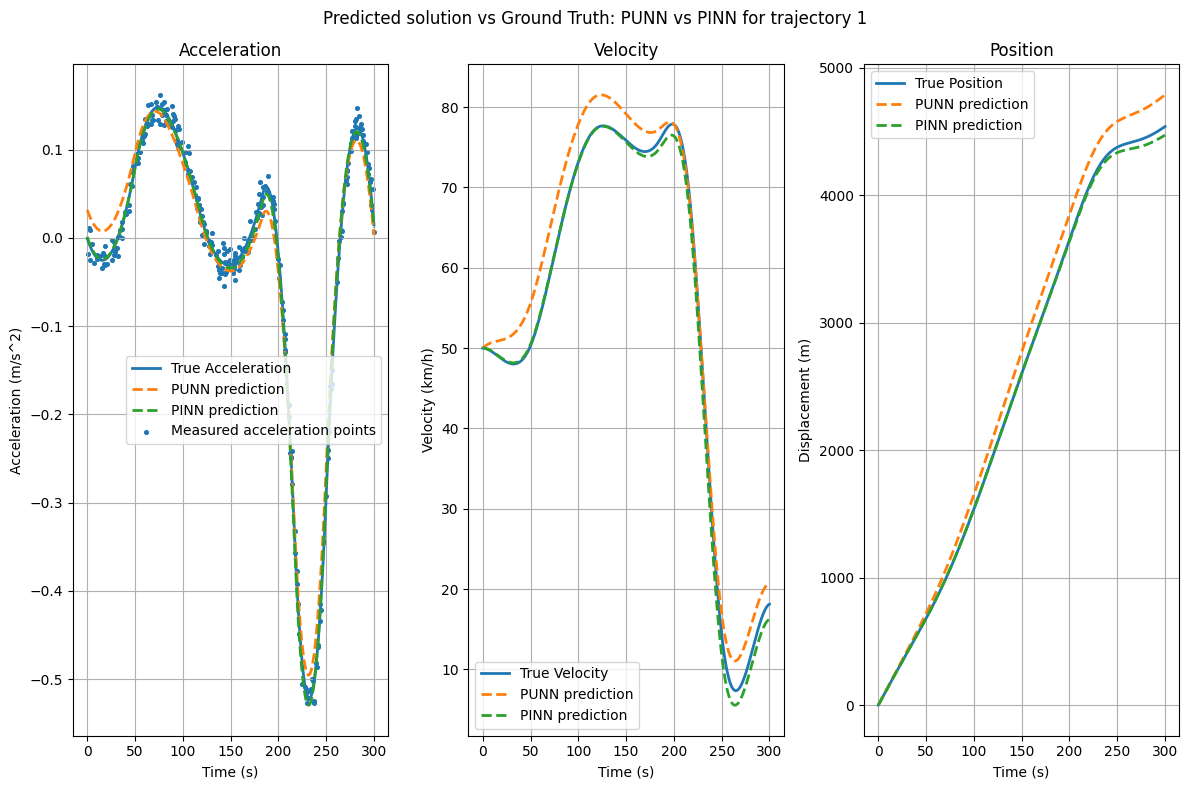

Testing trajectory (3) statistics: 
PUNN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 1.30506e-03, 3.61257e-02
MSE/RMSE for velocity: 4.08012e+01, 6.38758e+00
MSE/RMSE for position: 6.34534e+05, 7.96576e+02
PINN:
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE/RMSE for acceleration: 3.15476e-05, 5.61672e-03
MSE/RMSE for velocity: 2.71627e-01, 5.21178e-01
MSE/RMSE for position: 4.72215e+03, 6.87179e+01
----


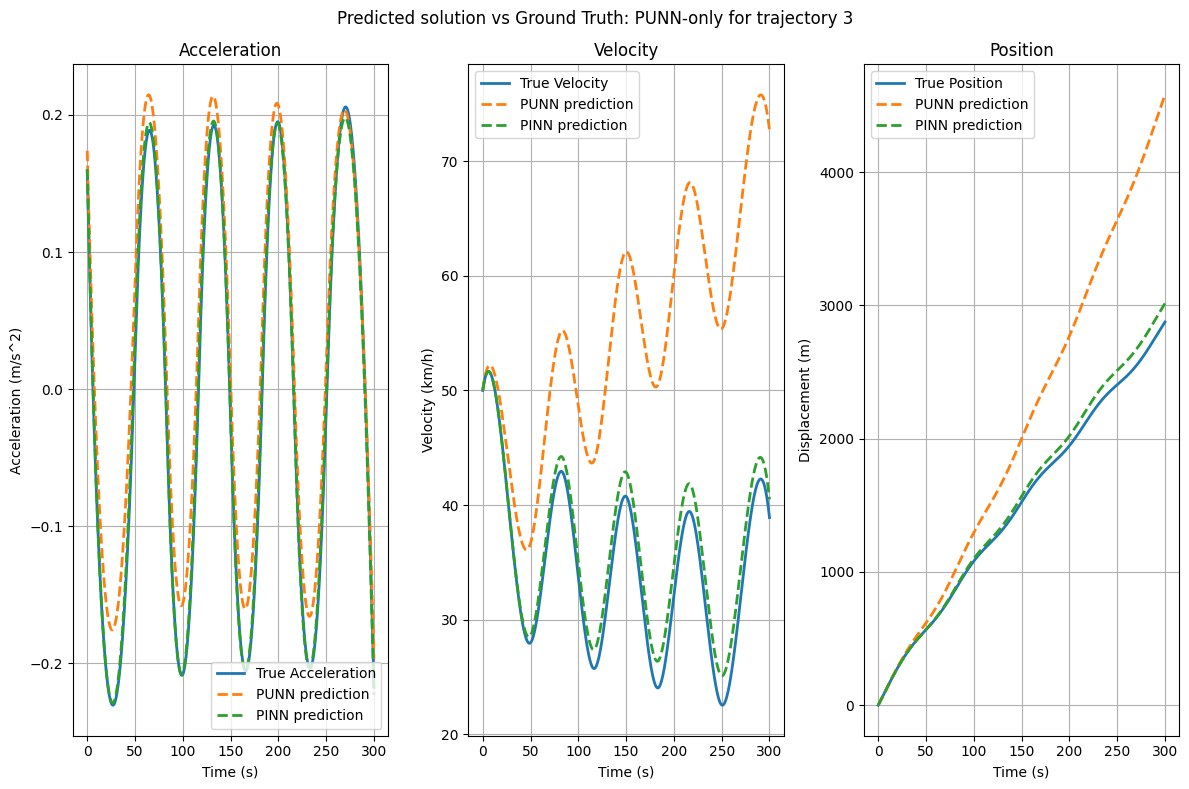

In [66]:
punn_model = load_model("models/punn_model_forward.h5", compile=False)  # Load model just for prediction
pinn_model = load_model("models/pinn_model_forward.h5", compile=False)  # Load model just for prediction

true_data = df_train_traj[["a_true", "v_true_m", "x_true"]].to_numpy()
print("Training trajectory (" + str(train_id) + ") statistics: ")
print("PUNN:")
punn_train_traj_eval = evaluate_results(model=punn_model, X_norm=X_norm, true_data=true_data)
print("PINN:")
pinn_train_traj_eval = evaluate_results(model=pinn_model, X_norm=X_norm, true_data=true_data)
print("----")
comparison_plot(t=t, true_data=true_data, meas_data=Y_mask,
    pred_data=[(punn_train_traj_eval, "PUNN prediction"), (pinn_train_traj_eval, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN vs PINN for trajectory " + str(train_id)
)

true_data_test = df_test_traj[["a_true", "v_true_m", "x_true"]].to_numpy()
print("Testing trajectory (" + str(test_id) + ") statistics: ")
print("PUNN:")
punn_test_traj_eval = evaluate_results(model=punn_model, X_norm=X_test_norm, true_data=true_data_test)
print("PINN:")
pinn_test_traj_eval = evaluate_results(model=pinn_model, X_norm=X_test_norm, true_data=true_data_test)
print("----")
comparison_plot(t=t, true_data=true_data_test, meas_data=None,
    pred_data=[(punn_test_traj_eval, "PUNN prediction"), (pinn_test_traj_eval, "PINN prediction")],
    suptitle="Predicted solution vs Ground Truth: PUNN-only for trajectory " + str(test_id)
)